Эксперименты...

In [ ]:
!pip install nltk
import nltk
nltk.download("wordnet")

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline
model_name = "emilyalsentzer/Bio_ClinicalBERT"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForTokenClassification.from_pretrained(model_name)

ner_pipeline = pipeline("ner", model=model, tokenizer=tokenizer, aggregation_strategy="simple")

data = data = pd.read_parquet("hf://datasets/gamino/wiki_medical_terms/wiki_medical_terms.parquet")


import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def clean_text_with_re(text):
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    tokens = text.split()
    cleaned_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(cleaned_tokens)

data["cleaned_text"] = data["page_text"].apply(clean_text_with_re)

print(data.head())

def extract_entities_from_text(text):
    max_length = 512
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=max_length)
    entities = ner_pipeline(text[:max_length])
    return entities

def build_knowledge_graph(data):
    G = nx.DiGraph()

    for _, row in data.iterrows():
        text = row["cleaned_text"]
        term = row["page_title"]

        entities = extract_entities_from_text(text)
        #print(entities)
        disease = None
        symptoms = []
        treatments = []

        for entity in entities:
          if entity['score'] > 0.6:
            if entity['entity_group'] == 'LABEL_1':
                disease = entity['word']
            elif entity['entity_group'] == 'LABEL_0':
                symptoms.append(entity['word'])
            else:
                treatments.append(entity['word'])

        if disease:
            G.add_node(disease, type='Disease')
            for symptom in symptoms:
                G.add_node(symptom, type='Symptom')
                G.add_edge(disease, symptom, relation="CAUSES")
            for treatment in treatments:
                G.add_node(treatment, type='Treatment')
                G.add_edge(disease, treatment, relation="TREATED_BY")

    return G

import time
start = time.time()
G = build_knowledge_graph(data)
end = time.time()
print("time", end-start)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cpu
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


                       page_title  \
0           Paracetamol poisoning   
1                      Acromegaly   
2               Actinic keratosis   
3  Congenital adrenal hyperplasia   
4        Adrenocortical carcinoma   

                                           page_text  \
0  Paracetamol poisoning, also known as acetamino...   
1  Acromegaly is a disorder that results from exc...   
2  Actinic keratosis (AK), sometimes called solar...   
3  Congenital adrenal hyperplasia (CAH) is a grou...   
4  Adrenocortical carcinoma  (ACC) is an aggressi...   

                                        cleaned_text  
0  paracetamol poisoning also known acetaminophen...  
1  acromegaly disorder result excess growth hormo...  
2  actinic keratosis ak sometimes called solar ke...  
3  congenital adrenal hyperplasia cah group autos...  
4  adrenocortical carcinoma acc aggressive cancer...  
time 2546.5066633224487


In [ ]:
nx.write_gexf(G,'/content/myGraphBig.gexf')

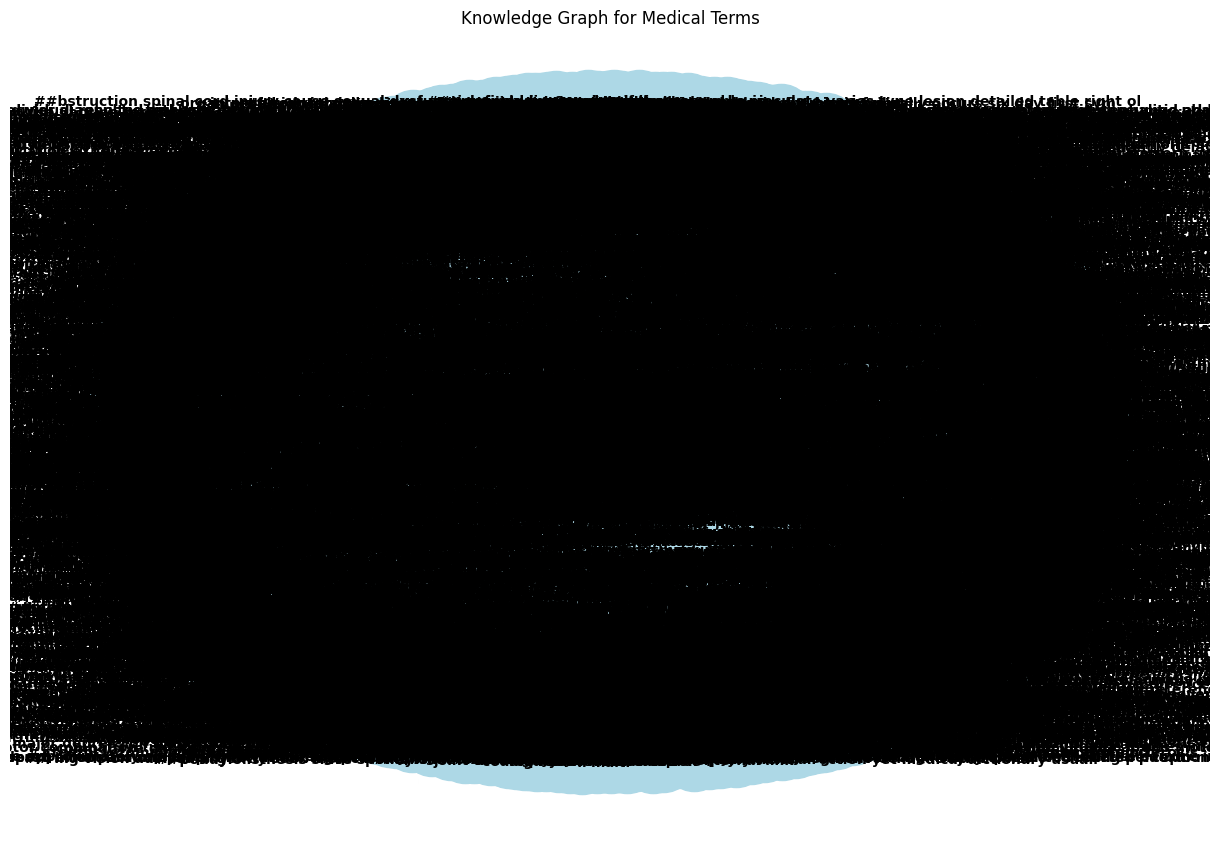

In [ ]:
def visualize_graph(G):
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G)
    node_labels = {node: node for node in G.nodes}
    nx.draw(G, pos, with_labels=True, node_size=2000, node_color="lightblue", font_size=10, font_weight="bold")

    edge_labels = nx.get_edge_attributes(G, "relation")
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color="red")

    plt.title("Knowledge Graph for Medical Terms")
    plt.show()

visualize_graph(G)

In [ ]:
# Проверяем количество узлов и рёбер
print(f"Number of nodes: {len(G.nodes)}")
print(f"Number of edges: {len(G.edges)}")

Number of nodes: 7174
Number of edges: 7286


Тут пробуем датасет с 200000 медицинскими абстрактами

In [ ]:
import zipfile

zip_file_path = '/content/train.txt.zip'
extract_dir = '/extracted'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)
    print(f"Файл распакован в {extract_dir}")

Файл распакован в /extracted


In [ ]:
!pip install sacremoses

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 9.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline
import time
import re
model_name = "microsoft/BIOGPT"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForTokenClassification.from_pretrained(model_name)

ner_pipeline = pipeline("ner", model=model, tokenizer=tokenizer, aggregation_strategy="simple")

def clean_text(text):
    # Удаляем слова "BACKGROUND", "METHODS", "CONCLUSIONS" и строки с кодами вида ###20497432
    text = re.sub(r'\b(BACKGROUND|METHODS|CONCLUSIONS|OBJECTIVE)\b', '', text)
    text = re.sub(r'###\d+', '', text)  # Удаляем строки с кодами вида ###20497432
    return text

with open("/extracted/train.txt", "r") as file:
    lines = file.readlines()

data = []
doc_id = None
doc_text = ""
text_count = 0

for line in lines:
    if text_count >= 2000:  # Ограничиваем 2000 текстами для проверки
        break
    if line.startswith("###"):
        if doc_id is not None:
            doc_text = clean_text(doc_text)
            data.append({"doc_id": doc_id, "text": doc_text.strip()})
        doc_id = line.strip().lstrip("###")
        doc_text = ""
    else:
        doc_text += line.strip() + " "
        if line.strip() == "":
            text_count += 1

if doc_id is not None and text_count < 2000:
    doc_text = clean_text(doc_text)
    data.append({"doc_id": doc_id, "text": doc_text.strip()})

df = pd.DataFrame(data)
def extract_entities_from_text_with_timing(text, score_threshold=0.95):
    start_time = time.time()
    entities = ner_pipeline(text[:512])
    end_time = time.time()
    elapsed_time = end_time - start_time
    filtered_entities = [entity for entity in entities if entity['score'] >= score_threshold]
    #print(filtered_entities)
    return filtered_entities


def build_knowledge_graph(data):
    G = nx.DiGraph()

    for _, row in data.iterrows():
        text = row["text"]

        if not text:
            continue
        entities = extract_entities_from_text_with_timing(text)

        disease = None
        symptoms = []
        treatments = []

        for entity in entities:
            if entity['entity_group'] == 'LABEL_1':
                disease = entity['word']
            elif entity['entity_group'] == 'LABEL_0':
                symptoms.append(entity['word'])
            else:
                treatments.append(entity['word'])

        if disease:
            G.add_node(disease, type='Disease')
            for symptom in symptoms:
                G.add_node(symptom, type='Symptom')
                G.add_edge(disease, symptom, relation="CAUSES")
            for treatment in treatments:
                G.add_node(treatment, type='Treatment')
                G.add_edge(disease, treatment, relation="TREATED_BY")

    return G


import time
start = time.time()
G = build_knowledge_graph(df)
end = time.time()
print("time", end-start)


Some weights of BioGptForTokenClassification were not initialized from the model checkpoint at microsoft/BIOGPT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cpu
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


KeyboardInterrupt: 

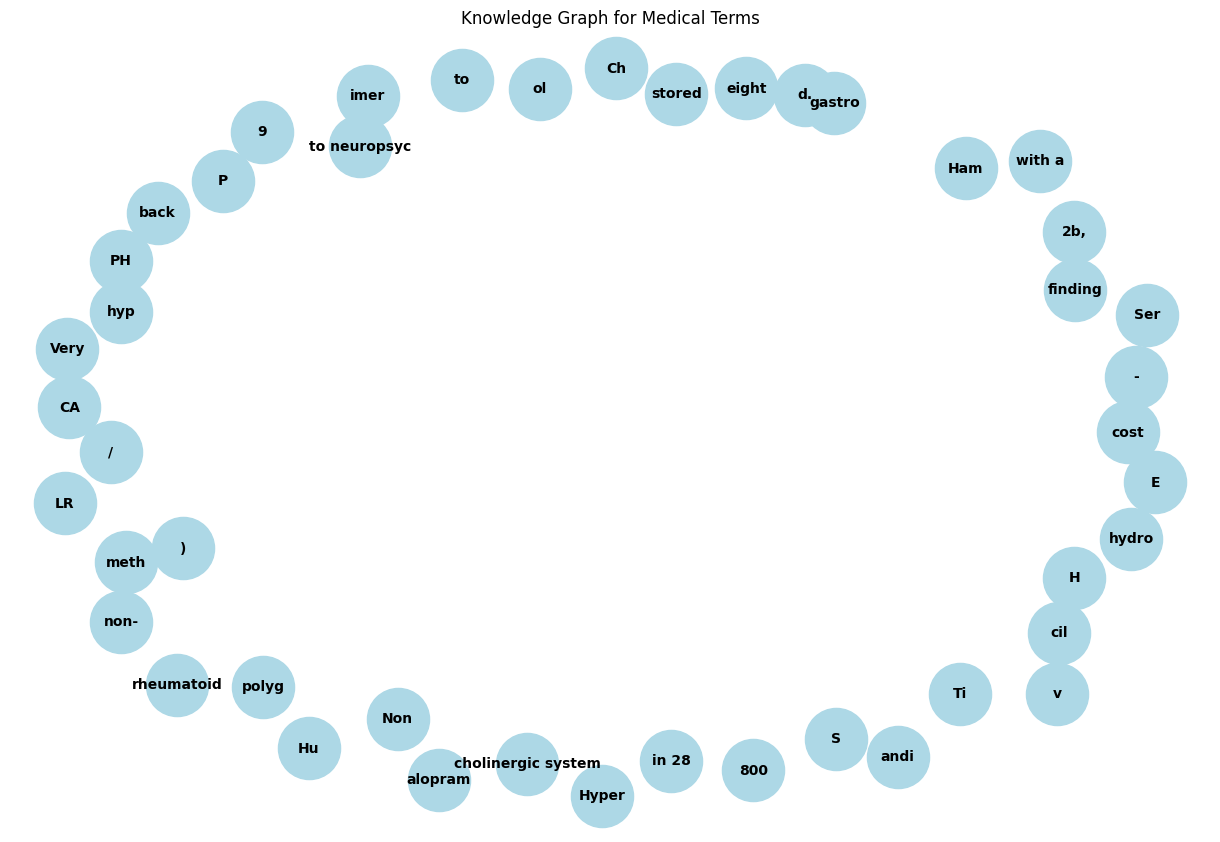

In [ ]:
def visualize_graph(G):
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G)
    node_labels = {node: node for node in G.nodes}
    nx.draw(G, pos, with_labels=True, node_size=2000, node_color="lightblue", font_size=10, font_weight="bold")
    edge_labels = nx.get_edge_attributes(G, "relation")
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color="red")

    plt.title("Knowledge Graph for Medical Terms")
    plt.show()

visualize_graph(G)

In [ ]:
# Проверяем количество узлов и рёбер
print(f"Number of nodes: {len(G.nodes)}")
print(f"Number of edges: {len(G.edges)}")

Number of nodes: 45
Number of edges: 2
